# Adaptive setting for epidemiological models
------------------------------------------------
Some details on Python implementation.

- SIR Models
- Adaptive Human Behavior

Jimmy Calvo-Monge

We consider the model:

$$
\begin{align}\label{model1}
    & \frac{dS}{dt}=  -g(\cdot)\beta \frac{SI}{N} + \mu N - \mu S. \nonumber\\
    & \frac{dI}{dt}= g(\cdot)\beta \frac{SI}{N} + \phi\frac{Z I}{N}-(\gamma+\mu)I. \nonumber \\
    & \frac{dZ}{dt}= \gamma I - \phi \frac{IZ}{N} - \mu Z.
\end{align}
$$

Here $N = S + I + Z$ is assumed constant. The function $g(\cdot)$ is the incidence rate of the model. From now on, we will take $g(\cdot)$ given by

$$
g(\cdot) = g(S,I,Z) = \frac{C^sC^iN}{SC^s + IC^i + ZC^z}.
$$

The likelihood of infection when contacted with a infected individual is given by $\beta$, the rate of recovery by $\gamma$, the rate of reinfection represented by $\phi$, and we have a demographic exit rate for the system given by $\mu$. The incidence rate, $g(\cdot)$, represents the contact rate between susceptible and infected individuals, implying that $g(\cdot)\beta$ acts as the rate at which susceptible become infected.

## Solve system of equations with 4 step Runge-Kutta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
# Import Markov Decision Module
import MDP

Solve system using $C^s, C^i, C^z$ constant in interval $[\texttt{start},\texttt{end}]$ with initial conditions $x_{00}$ and model parameters $\mu,\gamma,\beta,\phi$

In [2]:
class EpiModel():

    def __init__(self, mu, gamma, beta, phi, Cs, Ci, Cz, x00, start, end, **kwargs):

        # Initial parameters
        self.mu = mu
        self.gamma = gamma
        self.beta = beta
        self.phi = phi

        # R values:
        self.Rmu = self.mu/(self.mu + self.gamma)
        self.Rphi = self.phi/(self.mu + self.gamma)

        # Adaptive parameters
        self.Cs = Cs
        self.Ci = Ci
        self.Cz = Cz

        # Simulation parameters
        self.start = start
        self.end = end
        self.x00 = x00
        self.N = sum(x00)

        # For RK4
        self.dt = kwargs.get('dt', 0.1)
        
        # Loading Bar
        self.loadbar = kwargs.get('loadbar',False)

    # ============ Using Four Step Runge-Kutta ============ #
    # Taken from https://medium.com/geekculture/runge-kutta-numerical-integration-of-ordinary-differential-equations-in-python-9c8ab7fb279c

    def ode_system(self, _t, _y):
        """
        system of first order differential equations
        _t: discrete time step value
        _y: state vector [y1, y2, y3]
        """

        C = self.Cs*self.Ci*self.N / \
            (_y[0]*self.Cs + _y[1]*self.Ci + _y[2]*self.Cz)

        dsdt = -C*self.beta*_y[0]*(_y[1]/self.N) + \
            self.mu*self.N - self.mu*_y[0]
        didt = C*self.beta*_y[0]*(_y[1]/self.N) + self.phi * \
            _y[2]*(_y[1]/self.N) - (self.gamma + self.mu)*_y[1]
        dzdt = self.gamma*_y[1] - self.phi*_y[2]*(_y[1]/self.N) - self.mu*_y[2]

        return np.array([dsdt, didt, dzdt])

    def rk4(self, func, tk, _yk, _dt=0.01, **kwargs):
        """
        single-step fourth-order numerical integration (RK4) method
        func: system of first order ODEs
        tk: current time step
        _yk: current state vector [y1, y2, y3, ...]
        _dt: discrete time step size
        **kwargs: additional parameters for ODE system
        returns: y evaluated at time k+1
        """

        # evaluate derivative at several stages within time interval
        f1 = func(tk, _yk, **kwargs)
        f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), **kwargs)
        f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), **kwargs)
        f4 = func(tk + _dt, _yk + (f3 * _dt), **kwargs)

        # return an average of the derivative over tk, tk + dt
        return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

    def solve_odes_system_RK4(self):

        dt = self.dt
        time = np.arange(self.start, self.end + dt, dt)
        self.time = time

        # second order system initial conditions [y1, y2] at t = 1
        y0 = np.array(self.x00)

        # ==============================================================
        # propagate state

        # simulation results
        state_history = []

        # initialize yk
        yk = y0

        # intialize time
        t = 0

        # approximate y at time t
        if self.loadbar:
            for t in tqdm(time):
                state_history.append(yk)
                yk = self.rk4(self.ode_system, t, yk, dt)
        else:
            for t in time:
                state_history.append(yk)
                yk = self.rk4(self.ode_system, t, yk, dt)

        # convert list to numpy array
        state_history = np.array(state_history)

        self.full_solution = state_history

        self.S = state_history[:, 0]
        self.I = state_history[:, 1]
        self.Z = state_history[:, 2]

    def plot_ode_solution(self, **kwargs):

        title = kwargs.get('title','Plot')

        plt.plot(self.time, self.S, label="Susceptible")
        plt.plot(self.time, self.I, label="Infected")
        plt.plot(self.time, self.Z, label="Recovered")
        plt.title(f"Plot of S-I-Z functions ({title})")
        plt.xlabel("Time (t)")
        plt.ylabel("Number of individuals")
        plt.legend(loc="upper right")
        plt.rcParams["figure.figsize"] = (10, 6)
        plt.show()

An example from *SIR Dynamics with Economically Driven Contact Rates*, by B.Morin, C.Castillo-Chaves and E. Fenichel. Example in Figure 3, page 517.

### Solving the model with constant contact rates.

100%|█████████████████████████████████████████████████████████████████████████| 14001/14001 [00:00<00:00, 26517.14it/s]


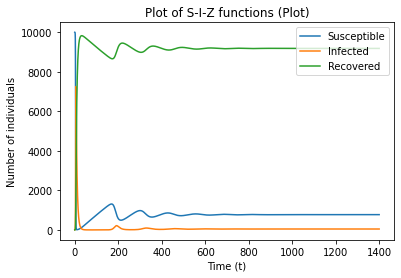

In [3]:
x00 = [9999,1,0]
N = sum(x00)

Delta = 10

# Initial parameters
mu = Delta/N
gamma = 0.2
beta = 0.2
phi = 0

kappa = 1  #C^I/C^S
theta = 1 #C^Z/C^S

Ci = 13
Cs = Ci/kappa
Cz = Cs*theta

start = 0
end = 1400

mod_ex = EpiModel(mu, gamma, beta, phi, Cs, Ci, Cz, x00, start, end, dt=0.1, loadbar=True)
mod_ex.solve_odes_system_RK4()
mod_ex.plot_ode_solution()

The algorithm now will be to solve the system in steps of length $\Delta t=1$, and at each step find the optimal $C^s$ to use.

## Obtain optimal $C^s$ in time steps
This $c_{s,t}^*$ needs to be obtained using an dynamic programming algorithm.
We import an abstract class of a Markov Decision Process.

### Adaptive model as a Markov Decision Process

In order to get a clearer idea behind the adaptive algorithm for obtaining the contact rates $C^h$, we recall the theoretical roots for these adaptive algorithms.

These are embedded inside the theory of **Markov Decision Processes**, a topin within a branch of Machine Learning called **Reinforcement Learning**.


A Markov Decision Process is an abstraction used to model a process of decision making by an individual or agent. It consists of the following:

- A space of **states** $\mathcal{S}$.
- A space of possible **actions** $\mathcal{A}$.
- A **progression over a time axis $t$}. Where, for each $t$ there's a state $S_t$ and the need to make a decision to take an action $A_t$ in order to move to the next time stage.
- An **immediate reward** $u_t^h: \mathcal{A} \to \mathbb{R}$ for each state $h$. Gives the reward/utility of choosing action $a$ at time $t$ if the current state is $h$.
- For each time stage $t$ and for each states $h,h' \in \mathcal{S}$, there's a **probability of transition** $p_{hh'}^t: \mathcal{A} \to [0,1]$, where $p_{hh'}^t(a)$ denotes **the probability that at time $t+1$ the state of the system becomes $h'$ if at the current time the state is $h$ and the agent takes decision $a$ to move forward**.
- A **planning horizon** $\tau$, decisions are made for $t=0,1,\cdots, \tau$.

These are the settings of a Markov Decision Process, the actual decision that the agent makes is what is known as a policy.

Let $(\mathcal{S},\mathcal{A},p_{hh'}^t)$ a Markov Decision Process (MDP). a **deterministic policy** is a series of functions $\{\pi^t: \mathcal{S} \to \mathcal{A}\}$, that for each time $t$ give the agent what action to take if depending of the state of the system. 

There are many possibilities for policies to take, however there's an optimal one.

The **optimal policy** for a MDP process is obtained through a process of backwards induction. For each state $h \in \mathcal{S}$, we define the value function $V_t(h)$ at time $t$. The optimal $a \in \mathcal{A}$ to choose at time $t$ when state is $h$ (this is $\pi^t(h)$) is computed using the **Bellman Equation** for $V_t(h)$:

$$
    \begin{align}\label{bellmantheoric}
        V_t(h) = \max_{a \in \mathcal{A}} \left\{
        u_t^h(a) + \delta \sum_{h' \in \mathcal{S}} p_{hh'}^t(a)V_{t+1}(h')
        \right\},
    \end{align}
$$
where $\delta$ is a **discount factor**.

This is computed using a process of backwards induction by means of the planning horizon. We start with an initial vector $(V_{t+\tau+1}(h), h \in \mathcal{S})$ and move back to find $V_t(h)$.

#### How the adaptive model is actually a Markov Decision Process

In the case of epidemiological models, our adaptive model is actually an example of an MDP, with the following parameters:

- The state state $\mathcal{S} = {s,i,z}$, the possible states for an individual at the epidemic system.
- The action state $\mathcal{A}= [0,C_{\max}]$, an interval of possible contact rates that can be made by an individual per time period.
- The immediate rewards $u_t^h(a) = (b^ha-a^2)^\gamma - a^h$, concave functions with a maxima.
- The transition probabilities, in this case they are
$$
    \begin{align*}
        \begin{pmatrix}
            p_{ss}^t(a) & p_{si}^t(a) & p_{sz}^t(a) \\
            p_{is}^t(a) & p_{ii}^t(a) & p_{iz}^t(a) \\
            p_{zs}^t(a) & p_{zi}^t(a) & p_{zz}^t(a) \\
        \end{pmatrix} = \begin{pmatrix}
            1 - p_{si}^t(a) & p_{si}^t(a) & 0 \\
            0 & 1- p_{iz}^t(a) & p_{iz}^t(a) \\
            0 & p_{zi}^t(a) & 1- p_{zi}^t(a) \\
        \end{pmatrix}
    \end{align*}
$$

Important: when there's no reinfection $p_{zi}^t \equiv 0.$ (This is the case with the model in Fenichel et al. In this case $p_{si}^t$ is given by equation 

$$
p_{si}^t = 1- \text{exp}\left( - \frac{\beta I_t C_t^s C_t^{i*}}{\S_tC_t^{s*} + I_tC_t^{i*}+ Z_tC_t^{z*}} \right)
$$

and $p_{iz}^t$ is the probability of recovery, given by $p_{iz}^t = P^z=1-e^{-\nu}$.

In this case Bellman's equation is  

$$
\begin{align}
    V_t(s) &= \max_{C^s \in \mathcal{A}} \left\{ 
    u_t^s(C^s) + \delta [p_{ss}^t(C^s)V_{t+1}(s) + p_{si}^t(C^s)V_{t+1}(i) ]
    \right\} \nonumber \\
    & = \max_{C^s \in \mathcal{A}} \left\{ 
    u_t^s(C^s) + \delta [(1-p_{si}^t(C^s))V_{t+1}(s) + p_{si}^t(C^s)V_{t+1}(i) ]
    \right\}.
\end{align}
$$

In [13]:
def find_optimal_Cs_at_time(mu, gamma, beta, phi,
                            t_start, x00,
                            tau, delta,
                            b_s, b_i, b_z,
                            a_s, a_i, a_z, nu):
    
    """
    mu, gamma, beta, phi: parameters from system of ODE's
    t_start: value of t at start of interval.
    x00: value of S,I,Z at the start of the interval.
    tau: planning horizon.
    delta: discount factor.
    
    Utility functions are 
    u_h(C) = (b_h*C - C^2)^nu - a_h, for h in {s,i,z}
    
    """
    
    # Decide the optimal Cs at time t.
    # Requires a projection over interval [t, t+tau]
    final_vals = []
    states = [0, 1, 2]
    Cs_options = range(1,20)
    
    # Use C_i, C_z as 0.5*b_i, 0.5*b_z [Max of utility functions for infected and recovered]
    C_i = 0.5*b_i
    C_z = 0.5*b_z
    
    # Cs_star c_{t,s}^* average choice made by susceptible individuals. We keep it constant
    # Decide c_{t,s} by adapting algorithm. Then put c_{s,t} as c_{s,t}^*.
    
    for Cs_star in Cs_options:
        
        # Project the model over the planning window period, this solves the system using Cs_t
        # from t_0 to t_0 + tau
        dt=0.1

        model_projection = EpiModel(mu, gamma, beta, phi, Cs_star, C_i, C_z, x00, t_start, t_start+tau, dt=dt)
        model_projection.solve_odes_system_RK4()
        S_proj, I_proj, Z_proj = model_projection.S, model_projection.I, model_projection.Z

        # Immediate rewards:
        def u_s(a):
            return (b_s*a - a**2)**nu - a_s
        def u_i(a):
            return (b_i*a - a**2)**nu - a_i
        def u_z(a):
            return (b_z*a - a**2)**nu - a_z

        # Transition Probability matrices:
        
        def P_ss(a):
            return 1 - P_si(a)
        def P_sz(a):
            return 0

        def P_is(a):
            return 0
        def P_ii(a):
            return math.exp(-1*gamma)
        def P_iz(a):
            return 1 - math.exp(-1*gamma)

        # No reinfection: (Important) #
        def P_zs(a):
            return 0
        def P_zi(a):
            return 0
        def P_zz(a):
            return 1
        
        # For each t in {0,1,2,...,tau} find P_t transition probability matrix.
        # P_{hk}(t): probability of going from state h to state k at time t.
        # P_{si}(t) depends on S(t),I(t),Z(t).
        
        reward_vector = np.array([u_s, u_i, u_z])
        rewards = [reward_vector]*tau
        trans_probs = []
        
        for t in range(tau):
            
            S_t, I_t, Z_t = S_proj[int(t/dt)], I_proj[int(t/dt)], Z_proj[int(t/dt)]
            phi_t = S_t*Cs_star + I_t*C_i + Z_t*C_z
            
            def P_si(a): 
                P_it = 1 - math.exp(-1*(beta*I_t*C_i*a)/phi_t)
                return P_it

            trans_prob_mat = np.array([
                [P_ss, P_si, P_sz],
                [P_is, P_ii, P_iz],
                [P_zs, P_zi, P_zz]
            ])
            
            trans_probs.append(trans_prob_mat)
            
        # Initialization Point:
        # Using [0,0,0] to start the backwards induction is not working.
        # Trying equation 7 from Fenichel et. al.
        
#         P_si_last = trans_probs[tau-1][0,1]
#         def vs1(C_st, vti):
#             I = I_proj[int(tau/dt)]
#             expr0 = 0.5*beta*b_i*I*math.exp(-1*(0.5*beta*b_i*I*C_st)/phi_t)/phi_t
#             expr1 = ((nu*(b_s*C_st - C_st*2)**(nu - 1))*(b_s - 2*C_st)) / expr0
#             expr2 = (1 - P_si_last(C_st))*expr1 + P_si_last(C_st)*vti
#             return (b_s*C_st - C_st*2)*nu - a_s - delta*expr2
#         C_st_tau_step = [vs1(C_st, vti = 0) for C_st in Cs_options]
#         Vs1s = max(C_st_tau_step)
#         init_point = [Vs1s, 0, 0]

        init_point = [0,0,0]

        # Use a Markov Decision Process with finite horizon to obtain the optimal policy and decision.
        MDP_adaptive = MDP.MDP(S=states, A=Cs_options,
                               rewards=rewards, trans_probs=trans_probs,
                               horizon=tau, delta=delta,
                               )
        MDP_adaptive.fit_optimal_values(verbose = True, init_point = init_point)
        final_values = MDP_adaptive.values[1]
        final_vals.append(final_values)

    Cs_opt = Cs_options[np.argmax(final_vals)]
    return Cs_opt

In [14]:
find_optimal_Cs_at_time(mu=10/10000, gamma=0.2, beta=0.2, phi=0,
                        t_start=0, x00=[9999,1,0],
                        tau=3, delta=0.9986,
                        b_s=24, b_i=24, b_z=24,
                        a_s=0, a_i=0, a_z=0, nu=0.2)

1

<p style="color:white; background-color: red; width:20%; margin:auto; text-align:center;"> It should return $c_{0,s}^* \approx 10$ </p>

Some problems with implementation.

## Solve system in discrete time steps, halting integration at each step to compute $C^s$